## Setting the Enviroment

In [ ]:
pip install spotipy

In [1]:
#Complete with your Credentials
import os
os.environ['SPOTIPY_CLIENT_ID'] = '' 
os.environ['SPOTIPY_CLIENT_SECRET'] = ''
os.environ['SPOTIPY_REDIRECT_URI'] = 'https://google.com'



In [ ]:
import pandas as pd
import numpy as np
import spotipy
from spotipy.oauth2 import SpotifyOAuth

In [ ]:
#Plotly
!wget https://raw.githubusercontent.com/MicrosoftDocs/mslearn-introduction-to-machine-learning/main/graphing.py
import graphing
import plotly.express as px
import plotly.graph_objects as go

## Development of the df_SI (Songs that I like!)


We are goint to create two DataFrames: one called df_SI, with the songs that I like, and another named df_NO with the ones that I do not like.

To extract the playlist, we need a DevAccount (check this link for more information: https://www.youtube.com/watch?v=cU8YH2rhN6A&t=1138s). After getting it, we execute the following code, that asks us for the obtained URL from the link below. We just copy and paste that URL into the box and click "OK".

In [ ]:
#We are going to log to retrieve my personal Library.
scope = "user-library-read"

sp = spotipy.Spotify(auth_manager=SpotifyOAuth(scope=scope,open_browser=False))

  

In [ ]:
#With the following code, we will create an array of all the IDs (URIS) of the songs that I have liked.
saved_tracks_resp = sp.current_user_saved_tracks()

number_of_tracks = saved_tracks_resp['total']
print('%d tracks' % number_of_tracks)

def save_only_some_fields(track_response):
    return {        
        'id': str(track_response['track']['id']),
        'title': str(track_response['track']['name']),
        'artists': [artist['name'] for artist in track_response['track']['artists']], 
        'popularity': track_response['track']['popularity'],
        'release_date': track_response['track']['album']['release_date'],
        'duration_ms': track_response['track']['duration_ms'],
        #,'added_at': track_response['added_at']
    }

tracks = [save_only_some_fields(track) for track in saved_tracks_resp['items']]

while saved_tracks_resp['next']:
    saved_tracks_resp = sp.next(saved_tracks_resp)
    tracks.extend([save_only_some_fields(track) for track in saved_tracks_resp['items']])

In [ ]:
#Here we will get them into a proper dataframe and will make some few transformations to get the songs in seconds and not miliseconds.
df_SI = pd.DataFrame(tracks)
pd.set_option('display.max_rows', len(tracks))
df_SI['duration_ms'] = df_SI['duration_ms'].apply(lambda duration: duration/1000)
df_SI = df_SI.rename(columns = {'duration_ms':'duration_s'})
df_SI.head()

,id,title,artists,popularity,release_date,duration_s
0,6OMjtuz1sYVsHpdeZPUR1n,Sarà perché ti amo,[Ricchi E Poveri],58,1997-09-08,189.800
1,1mfOVu9M9P4NfZZvotQ7NV,Cruel to Be Kind,[Nick Lowe],0,2011-03-13,210.106
2,0J5xhsP8FsUCH5W6ZQLJJr,Dancin' Til Dawn,[Lenny Kravitz],29,2008-01-01,309.746
3,4F1V29ygbAKbKCQDgt4z9f,The Secret Life of Arabia - 2017 Remaster,[David Bowie],34,1977,226.906
4,2EC9IJj7g0mN1Q5VrZkiYY,Rebel Rebel - 2016 Remaster,[David Bowie],70,1974-05-24,274.746


In [ ]:
#Now we will add all the features with which we are going to make the project.
audio_features = {}

for idd in df_SI['id'].tolist():
    audio_features[idd] = sp.audio_features(idd)[0]

df_SI['danceability'] = df_SI['id'].apply(lambda idd: audio_features[idd]['danceability'])
df_SI['energy'] = df_SI['id'].apply(lambda idd: audio_features[idd]['energy'])
df_SI['key'] = df_SI['id'].apply(lambda idd: str(audio_features[idd]['key']))
df_SI['loudness'] = df_SI['id'].apply(lambda idd: audio_features[idd]['loudness'])
df_SI['mode'] = df_SI['id'].apply(lambda idd: audio_features[idd]['mode'])
df_SI['acousticness'] = df_SI['id'].apply(lambda idd: audio_features[idd]['acousticness'])
df_SI['instrumentalness'] = df_SI['id'].apply(lambda idd: audio_features[idd]['instrumentalness'])
df_SI['speechiness'] = df_SI['id'].apply(lambda idd: audio_features[idd]['speechiness'])
df_SI['liveness'] = df_SI['id'].apply(lambda idd: audio_features[idd]['liveness'])
df_SI['valence'] = df_SI['id'].apply(lambda idd: audio_features[idd]['valence'])
df_SI['tempo'] = df_SI['id'].apply(lambda idd: audio_features[idd]['tempo'])
df_SI['time_signature'] = df_SI['id'].apply(lambda idd: audio_features[idd]['time_signature'])


In [ ]:
#Column for differentiate the df_NO(0) from the df_SI(1)
df_SI['label']=1

## Development of the df_NO (Songs that I don't like)

It will be based in public playlists of Reggeaton and Cumbia 420

In [ ]:
# Here we define a function that allow us to extract the features from a playlist longer than 100 songs:
def get_playlist_tracks_more_than_100_songs(username, playlist_id):
    results = sp.user_playlist_tracks(username,playlist_id)
    tracks = results['items']
    while results['next']:
        results = sp.next(results)
        tracks.extend(results['items'])
    results = tracks    

    playlist_tracks_id = []
    playlist_tracks_titles = []
    playlist_tracks_artists = []
    playlist_tracks_first_artists = []
    playlist_tracks_first_release_date = []
    playlist_tracks_popularity = []

    for i in range(len(results)):
        print(i) # Counter
        if i == 0:
            playlist_tracks_id = results[i]['track']['id']
            playlist_tracks_titles = results[i]['track']['name']
            playlist_tracks_first_release_date = results[i]['track']['album']['release_date']
            playlist_tracks_popularity = results[i]['track']['popularity']

            artist_list = []
            for artist in results[i]['track']['artists']:
                artist_list= artist['name']
            playlist_tracks_artists = artist_list

            features = sp.audio_features(playlist_tracks_id)
            features_df = pd.DataFrame(data=features, columns=features[0].keys())
            features_df['title'] = playlist_tracks_titles
            features_df['artists'] = playlist_tracks_artists
            features_df['popularity'] = playlist_tracks_popularity
            features_df['release_date'] = playlist_tracks_first_release_date
            features_df = features_df[['id', 'title', 'artists', 'popularity', 'release_date','duration_ms',
                                       'danceability', 'energy', 'key', 'loudness',
                                       'mode', 'acousticness', 'instrumentalness', 'speechiness',
                                       'liveness', 'valence', 'tempo',
                                        'time_signature']]
            continue
        else:
            try:
                playlist_tracks_id = results[i]['track']['id']
                playlist_tracks_titles = results[i]['track']['name']
                playlist_tracks_first_release_date = results[i]['track']['album']['release_date']
                playlist_tracks_popularity = results[i]['track']['popularity']
                artist_list = []
                for artist in results[i]['track']['artists']:
                    artist_list= artist['name']
                playlist_tracks_artists = artist_list
                features = sp.audio_features(playlist_tracks_id)
                new_row = {'id':[playlist_tracks_id],
               'title':[playlist_tracks_titles],
               'artists':[playlist_tracks_artists],
               'popularity':[playlist_tracks_popularity],
               'release_date':[playlist_tracks_first_release_date],
               'duration_ms':[features[0]['duration_ms']],
               'danceability':[features[0]['danceability']],
               'energy':[features[0]['energy']],
               'key':[features[0]['key']],
               'loudness':[features[0]['loudness']],
               'mode':[features[0]['mode']],
               'acousticness':[features[0]['acousticness']],
               'instrumentalness':[features[0]['instrumentalness']],
              'speechiness':[features[0]['speechiness']],
                'liveness':[features[0]['liveness']],
               'valence':[features[0]['valence']],
               'tempo':[features[0]['tempo']],
               'time_signature':[features[0]['time_signature']]
               }

                dfs = [features_df, pd.DataFrame(new_row)]
                features_df = pd.concat(dfs, ignore_index = True)
            except:
                continue
                
    return features_df

In [ ]:
#150 songs of a REGGEATON Playlist
df_NO_1=get_playlist_tracks_more_than_100_songs("spotify","4qmV1veTGtXVEmAPg9aPzs") 

In [ ]:
#150 songs of a 'CUMBIA 420' Playlist
df_NO_2=get_playlist_tracks_more_than_100_songs("spotify",'0zBP5FKXBng0S8Yz5GUUD0').head(150)

In [ ]:
#150 songs of a 'REGGEATON CLÁSICO' Playlist
df_NO_3=get_playlist_tracks_more_than_100_songs("spotify",'6v7CenqsUTh2TQNk1I848c').head(100)

In [ ]:
df_NO=pd.concat([df_NO_1, df_NO_2, df_NO_3])

In [ ]:
df_NO.head()

,id,title,artists,popularity,release_date,duration_ms,danceability,energy,key,loudness,mode,acousticness,instrumentalness,speechiness,liveness,valence,tempo,time_signature
0,4nrPB8O7Y7wsOCJdgXkthe,"Shakira: Bzrp Music Sessions, Vol. 53",Shakira,96,2023-01-11,218289,0.778,0.632,2,-5.600,0,0.2740,0.000000,0.0493,0.0915,0.498,122.104,4
1,2oiixB9QMIzhWaHGVlQx4g,Yandel 150,Feid,88,2022-12-20,216148,0.783,0.729,6,-3.549,0,0.0492,0.000272,0.0691,0.1000,0.580,167.968,4
2,5ww2BF9slyYgNOk37BlC4u,La Bachata,Manuel Turizo,92,2022-05-26,162638,0.835,0.679,7,-5.329,0,0.5830,0.000002,0.0364,0.2180,0.850,124.980,4
3,1j4yhkxSCEDmiLVKjpYKWq,LA HORA Y EL DÍA,Dalex,67,2023-02-16,217255,0.806,0.830,7,-3.767,0,0.1170,0.000000,0.0981,0.1010,0.663,81.010,4
4,5MxFWjuqQIsbNWbMdMdbli,La Jumpa,Bad Bunny,87,2022-11-30,255693,0.713,0.703,8,-5.769,1,0.2980,0.000000,0.1940,0.3210,0.576,123.060,4


In [ ]:
#Few changes to alter from miliseconds to seconds.
pd.set_option('display.max_rows', len(tracks))
df_NO['duration_ms'] = df_NO['duration_ms'].apply(lambda duration: duration/1000)
df_NO = df_NO.rename(columns = {'duration_ms':'duration_s'})


In [ ]:
#Column for differentiate the df_NO(0) from the df_SI(1)
df_NO['label']=0

In [ ]:
df_SI.head()

,id,title,artists,popularity,release_date,duration_s,danceability,energy,key,loudness,mode,acousticness,instrumentalness,speechiness,liveness,valence,tempo,time_signature,label
0,6OMjtuz1sYVsHpdeZPUR1n,Sarà perché ti amo,[Ricchi E Poveri],58,1997-09-08,189.800,0.825,0.752,4,-8.134,1,0.12200,0.000000,0.0373,0.0655,0.963,120.190,4,1
1,1mfOVu9M9P4NfZZvotQ7NV,Cruel to Be Kind,[Nick Lowe],0,2011-03-13,210.106,0.697,0.664,0,-10.406,1,0.05970,0.000003,0.0261,0.0427,0.811,131.686,4,1
2,0J5xhsP8FsUCH5W6ZQLJJr,Dancin' Til Dawn,[Lenny Kravitz],29,2008-01-01,309.746,0.897,0.695,9,-6.384,0,0.19000,0.034900,0.0317,0.0773,0.965,101.089,4,1
3,4F1V29ygbAKbKCQDgt4z9f,The Secret Life of Arabia - 2017 Remaster,[David Bowie],34,1977,226.906,0.553,0.877,2,-7.752,0,0.00994,0.007510,0.0474,0.1110,0.912,104.752,4,1
4,2EC9IJj7g0mN1Q5VrZkiYY,Rebel Rebel - 2016 Remaster,[David Bowie],70,1974-05-24,274.746,0.635,0.686,9,-15.648,1,0.20900,0.017600,0.0530,0.2820,0.464,125.988,4,1


In [ ]:
df_NO.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 400 entries, 0 to 99
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                400 non-null    object 
 1   title             400 non-null    object 
 2   artists           400 non-null    object 
 3   popularity        400 non-null    int64  
 4   release_date      400 non-null    object 
 5   duration_s        400 non-null    float64
 6   danceability      400 non-null    float64
 7   energy            400 non-null    float64
 8   key               400 non-null    int64  
 9   loudness          400 non-null    float64
 10  mode              400 non-null    int64  
 11  acousticness      400 non-null    float64
 12  instrumentalness  400 non-null    float64
 13  speechiness       400 non-null    float64
 14  liveness          400 non-null    float64
 15  valence           400 non-null    float64
 16  tempo             400 non-null    float64
 17

In [ ]:
df_SI.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 404 entries, 0 to 403
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype  
---  ------            --------------  -----  
 0   id                404 non-null    object 
 1   title             404 non-null    object 
 2   artists           404 non-null    object 
 3   popularity        404 non-null    int64  
 4   release_date      404 non-null    object 
 5   duration_s        404 non-null    float64
 6   danceability      404 non-null    float64
 7   energy            404 non-null    float64
 8   key               404 non-null    object 
 9   loudness          404 non-null    float64
 10  mode              404 non-null    int64  
 11  acousticness      404 non-null    float64
 12  instrumentalness  404 non-null    float64
 13  speechiness       404 non-null    float64
 14  liveness          404 non-null    float64
 15  valence           404 non-null    float64
 16  tempo             404 non-null    float64
 1

Now we are going to make some changes in the format that will allow us to match them and merge them.

In [ ]:
df_SI["key"] = df_SI['key'].astype('int')

In [ ]:
df_SI["release_date"] = pd.to_datetime(df_SI["release_date"])

In [ ]:
df_NO["release_date"] = pd.to_datetime(df_NO["release_date"])

In [ ]:
df_SI.head()

,id,title,artists,popularity,release_date,duration_s,danceability,energy,key,loudness,mode,acousticness,instrumentalness,speechiness,liveness,valence,tempo,time_signature,label
0,6OMjtuz1sYVsHpdeZPUR1n,Sarà perché ti amo,[Ricchi E Poveri],58,1997-09-08,189.800,0.825,0.752,4,-8.134,1,0.12200,0.000000,0.0373,0.0655,0.963,120.190,4,1
1,1mfOVu9M9P4NfZZvotQ7NV,Cruel to Be Kind,[Nick Lowe],0,2011-03-13,210.106,0.697,0.664,0,-10.406,1,0.05970,0.000003,0.0261,0.0427,0.811,131.686,4,1
2,0J5xhsP8FsUCH5W6ZQLJJr,Dancin' Til Dawn,[Lenny Kravitz],29,2008-01-01,309.746,0.897,0.695,9,-6.384,0,0.19000,0.034900,0.0317,0.0773,0.965,101.089,4,1
3,4F1V29ygbAKbKCQDgt4z9f,The Secret Life of Arabia - 2017 Remaster,[David Bowie],34,1977-01-01,226.906,0.553,0.877,2,-7.752,0,0.00994,0.007510,0.0474,0.1110,0.912,104.752,4,1
4,2EC9IJj7g0mN1Q5VrZkiYY,Rebel Rebel - 2016 Remaster,[David Bowie],70,1974-05-24,274.746,0.635,0.686,9,-15.648,1,0.20900,0.017600,0.0530,0.2820,0.464,125.988,4,1


## Dataframe Merge

In this step, first we will merge both dataframes, and then, we will shuffle the rows, setting a random seed (random_state) equal 1 in order to be able to mantain the df sorted in the same way in case we want to repeat the experiment.

In [ ]:
df=pd.concat([df_NO, df_SI])

In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 804 entries, 0 to 403
Data columns (total 19 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   id                804 non-null    object        
 1   title             804 non-null    object        
 2   artists           804 non-null    object        
 3   popularity        804 non-null    int64         
 4   release_date      804 non-null    datetime64[ns]
 5   duration_s        804 non-null    float64       
 6   danceability      804 non-null    float64       
 7   energy            804 non-null    float64       
 8   key               804 non-null    int64         
 9   loudness          804 non-null    float64       
 10  mode              804 non-null    int64         
 11  acousticness      804 non-null    float64       
 12  instrumentalness  804 non-null    float64       
 13  speechiness       804 non-null    float64       
 14  liveness          804 non-

In [ ]:
#Mix
from sklearn.utils import shuffle
df = shuffle(df, random_state=1)

In [ ]:
df=df.reset_index()

In [ ]:
 #df = df.drop('index', axis=1)

In [ ]:
df.head()

,index,id,title,artists,popularity,release_date,duration_s,danceability,energy,key,loudness,mode,acousticness,instrumentalness,speechiness,liveness,valence,tempo,time_signature,label
0,8,1DxEbt6OSbrkRthk6pjZue,MERCHO,Nico Valdi,83,2022-12-16,161.452,0.838,0.790,6,-1.602,0,0.4310,0.000003,0.1080,0.1840,0.962,92.927,4,0
1,391,01jBLs7IZQzPt3dVdn5rDa,True Faith '94,[New Order],54,1994-01-01,335.533,0.605,0.907,0,-3.560,1,0.0158,0.015800,0.0330,0.0697,0.965,117.511,4,1
2,171,3Dik3Z6fZyHd0LozpXHYzP,Corazón de Poeta,[Jeanette],28,1992-05-25,280.000,0.697,0.486,6,-13.679,0,0.3600,0.001600,0.0294,0.0795,0.678,115.197,4,1
3,74,5DEucyKzqSS0fqYGdT0JGL,Pegate - Turreo Edit,DJ Mutha,47,2022-04-12,171.856,0.780,0.463,7,-7.477,1,0.0807,0.000000,0.1100,0.0955,0.431,139.544,3,0
4,98,5UXuombq8sj6a1QW5GUl4A,Chau... No Va Más...! (with Atilio Stampone y ...,"[Roberto Goyeneche, Atilio Stampone y su Orque...",13,2000-03-10,221.226,0.416,0.402,3,-8.801,1,0.9160,0.000193,0.0491,0.1930,0.467,104.308,4,1


In [ ]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 804 entries, 0 to 803
Data columns (total 20 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   index             804 non-null    int64         
 1   id                804 non-null    object        
 2   title             804 non-null    object        
 3   artists           804 non-null    object        
 4   popularity        804 non-null    int64         
 5   release_date      804 non-null    datetime64[ns]
 6   duration_s        804 non-null    float64       
 7   danceability      804 non-null    float64       
 8   energy            804 non-null    float64       
 9   key               804 non-null    int64         
 10  loudness          804 non-null    float64       
 11  mode              804 non-null    int64         
 12  acousticness      804 non-null    float64       
 13  instrumentalness  804 non-null    float64       
 14  speechiness       804 non-

##EDA

In [ ]:
#Setting up in "positive" the feature "loudness"
df_SI['loudness']=df_SI['loudness']*-1
df_NO['loudness']=df_NO['loudness']*-1
df['loudness']=df['loudness']*-1

In [ ]:
#Main features of the DF SI
df_SI_features_mean=(df_SI.describe().loc[['mean',"max","min"],['danceability','energy','valence','acousticness','liveness','speechiness','instrumentalness']]).T.sort_values("mean", ascending=False)

In [ ]:
fig1=px.bar(df_SI_features_mean, y='mean',title="Mean of Audio-Feautes in df_SI",text_auto=True, width=700, height=400)
fig1.update_layout(xaxis_title='Audio Features')
fig1.update_traces(marker_color='#b20710', marker_line_color='rgb(8,48,107)',
                  marker_line_width=1.5, opacity=0.6)
fig1.show()
print('')

In [ ]:
#Main features of the DF_NO
df_NO_features_mean=(df_NO.describe().loc[['mean',"max","min"],['danceability','energy','valence','acousticness','liveness','speechiness','instrumentalness']]).T.sort_values("mean", ascending=False)

In [ ]:
fig1=px.bar(df_NO_features_mean, y='mean',title="Mean of Audio-Feautes in df_NO",text_auto=True, width=700, height=400)
fig1.update_layout(xaxis_title='Audio Features')
fig1.show()
print('')

In [ ]:
#Comparing the difference between both dataframes
df_features_mean=df.groupby('label')[['danceability','energy','valence','acousticness','liveness','speechiness','instrumentalness']].mean().T
df_features_mean.head()

label,0,1
danceability,0.767990,0.567342
energy,0.713562,0.511333
valence,0.648973,0.542710
acousticness,0.196698,0.345461
liveness,0.175935,0.168591


In [ ]:
df_features_mean['difference_mean']=(df_features_mean[1]-df_features_mean[0]).round(3)
df_features_mean['positive'] = (df_features_mean['difference_mean']>=0)

In [ ]:
df_features_mean=df_features_mean.sort_values('difference_mean', ascending=False)

In [ ]:
fig1=px.bar(df_features_mean, y='difference_mean',title="Mean differences between df_SI and df_NO",text_auto=True, width=700, height=400, color='positive',
                color_discrete_map={
                    True: '#b20710',
                    False: 'blue'
                    },opacity=0.6
)

newnames = {'True':'df_SI', 'False': 'df_NO'}
fig1.for_each_trace(lambda t: t.update(name = newnames[t.name],
                                      legendgroup = newnames[t.name],
                                      hovertemplate = t.hovertemplate.replace(t.name, newnames[t.name])
                                     ))

fig1.update_layout(
    legend_title="")

fig1.show()
print('')

## ¿Can we Cluster the songs?

In the meantime, I was also interested in checking if we can make a K means Cluster that would classify properly between the 2 datasets. However, I didn't go too far in this approach as it wasn't the main aim of this project, but as we can see, if we divide them in 2 clusters (as the dfs), the model divides the songs pretty decently, although it's not too precise. 

In order to improve the model (specially around 0 in x-axis), an adjustment in the hyperparameters would be definitely necessary.

In [ ]:
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline


In [ ]:
#Songs Cluster
song_cluster_pipeline = Pipeline([('scaler', StandardScaler()), 
                                  ('kmeans', KMeans(n_clusters=2, 
                                   verbose=False))
                                 ], verbose=False)

X = (df.select_dtypes(np.number)).drop('label', axis=1)
number_cols = list(X.columns)
song_cluster_pipeline.fit(X)
song_cluster_labels = song_cluster_pipeline.predict(X)
df['cluster_label'] = song_cluster_labels

In [ ]:
# Visualizing the Clusters with PCA

from sklearn.decomposition import PCA

pca_pipeline = Pipeline([('scaler', StandardScaler()), ('PCA', PCA(n_components=2))])
song_embedding = pca_pipeline.fit_transform(X)
projection = pd.DataFrame(columns=['x', 'y'], data=song_embedding)
projection['title'] = df['title']
projection['cluster'] = df['cluster_label']

fig = px.scatter(
    projection, x='x', y='y', color='cluster', hover_data=['x', 'y', 'title'])
fig.show()

## TRAINING

Our First step is to separate features from label, and then create a proper Train and Test dataframe. As we can see later, we get fair enough results with just a Logistic Regression, being this our main model. All the validation ratios as Accuracy, Precision, and Recall are over 0,90 which is a good sign of a proper model.
 On the other hand, the confusion matrix shows a very intense diagonal color, indicating that the test values are properly classified.

In [ ]:
X, y = df[['duration_s',	'danceability',	'energy',	'loudness',	'mode',	'acousticness',	'instrumentalness',	'speechiness',	'liveness',	'valence','tempo']].values, df['label'].values

from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.30, random_state=1)

print ('Training Set: %d rows\nTest Set: %d rows' % (X_train.shape[0], X_test.shape[0]))

Training Set: 562 rows
Test Set: 242 rows


In [ ]:
#Logistic Model


from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import StandardScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC

# Define preprocessing for numeric columns (scale them)
feature_columns = [0,1,2,3,4,5,6,7,8,9,10]
feature_transformer = Pipeline(steps=[
    ('scaler', StandardScaler())
    ])

# Create preprocessing steps
preprocessor = ColumnTransformer(
    transformers=[
        ('preprocess', feature_transformer, feature_columns)])

# Create training pipeline
pipeline = Pipeline(steps=[('preprocessor', preprocessor),
                           ('regressor', LogisticRegression())])

# fit the pipeline to train a linear regression model on the training set
multi_model = pipeline.fit(X_train, y_train)
print (multi_model)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('preprocess',
                                                  Pipeline(steps=[('scaler',
                                                                   StandardScaler())]),
                                                  [0, 1, 2, 3, 4, 5, 6, 7, 8, 9,
                                                   10])])),
                ('regressor', LogisticRegression())])


Overall Accuracy: 0.9586776859504132
Overall Precision: 0.9590450710022638
Overall Recall: 0.9581650119821978
Average AUC: 0.9941116056145156


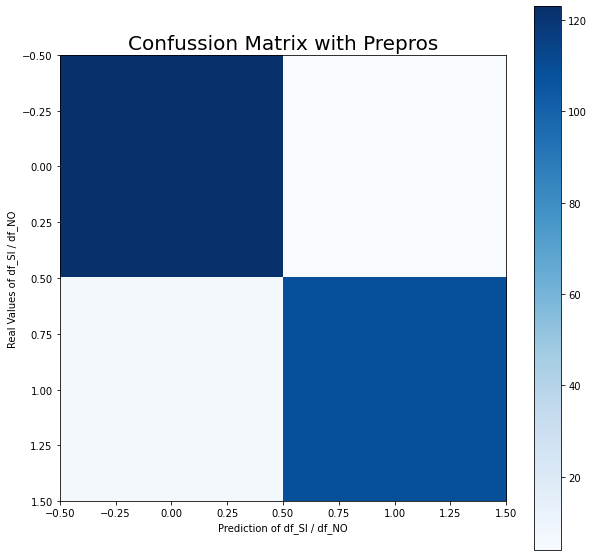

In [ ]:
#LOGISTIC with preprocessing and predictions

# Get predictions from test data
predictions = multi_model.predict(X_test)
predictions_prob = multi_model.predict_proba(X_test)

# Overall metrics
from sklearn.metrics import accuracy_score, precision_score, recall_score, roc_curve, roc_auc_score

%matplotlib inline


print("Overall Accuracy:",accuracy_score(y_test, predictions))
print("Overall Precision:",precision_score(y_test, predictions, average='macro'))
print("Overall Recall:",recall_score(y_test, predictions, average='macro'))
print('Average AUC:', roc_auc_score(y_test,predictions_prob[:,1]))

#Confussion Matrix - Heat Map
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

mcm = confusion_matrix(y_test, predictions)
plt.figure(figsize=(10,10)) 
plt.imshow(mcm, interpolation="nearest", cmap=plt.cm.Blues)
plt.colorbar()
plt.title("Confussion Matrix with Prepros", fontsize = 20)
plt.xlabel("Prediction of df_SI / df_NO")
plt.ylabel("Real Values of df_SI / df_NO")

plt.show()

In [ ]:
#Export model
import joblib

filename = './spotify_recommender.pkl'
joblib.dump(multi_model, filename)

['./spotify_recommender.pkl']

## PREDICTIONS

Finally, it is time to test our model, so we select a Simple Minds' 1985 song, "Alive and Kicking", which is one my favourite and is not on the playlist and as a song that I do not like, we choose "Dile" by Don Omar. 


In [ ]:
artist= 'Simple Minds'
track= 'Alive and Kicking'

track_prueba = sp.search(q='artist:' + artist + ' track:' + track, type='track')
track_prueba_URI = track_prueba['tracks']['items'][0]['id']
track_prueba_duration = track_prueba['tracks']['items'][0]['duration_ms']
track_prueba_audio_features=pd.DataFrame.from_dict(sp.audio_features(track_prueba_URI))
track_prueba_df=track_prueba_audio_features.loc[[0],['danceability',	'energy',	'loudness',	'mode',	'acousticness',	'instrumentalness',	'speechiness',	'liveness',	'valence','tempo']]
track_prueba_df.insert(0,'duration_s', track_prueba_duration/1000)
track_prueba_df['loudness']=track_prueba_df['loudness']*-1
track_prueba_df

,duration_s,danceability,energy,loudness,mode,acousticness,instrumentalness,speechiness,liveness,valence,tempo
0,289.453,0.572,0.913,4.26,1,0.0753,0.000015,0.0362,0.128,0.561,103.265


In [ ]:
# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array(track_prueba_df).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
results = loaded_model.predict(X_new)
print('Predictions:')
for prediction in results:
    print(round(prediction,2))

New sample: [289.453, 0.572, 0.913, 4.26, 1.0, 0.0753, 1.5e-05, 0.0362, 0.128, 0.561, 103.265]
Predictions:
1


In [ ]:
artist= 'Don Omar'
track= 'Dile'

track_prueba = sp.search(q='artist:' + artist + ' track:' + track, type='track')
track_prueba_URI = track_prueba['tracks']['items'][0]['id']
track_prueba_duration = track_prueba['tracks']['items'][0]['duration_ms']
track_prueba_audio_features=pd.DataFrame.from_dict(sp.audio_features(track_prueba_URI))
track_prueba_df=track_prueba_audio_features.loc[[0],['danceability',	'energy',	'loudness',	'mode',	'acousticness',	'instrumentalness',	'speechiness',	'liveness',	'valence','tempo']]
track_prueba_df.insert(0,'duration_s', track_prueba_duration/1000)
track_prueba_df['loudness']=track_prueba_df['loudness']*-1
track_prueba_df

,duration_s,danceability,energy,loudness,mode,acousticness,instrumentalness,speechiness,liveness,valence,tempo
0,204.6,0.817,0.714,7.501,0,0.184,0.000132,0.141,0.042,0.714,94.001


In [ ]:
# Load the model from the file
loaded_model = joblib.load(filename)

# Create a numpy array containing a new observation (for example tomorrow's seasonal and weather forecast information)
X_new = np.array(track_prueba_df).astype('float64')
print ('New sample: {}'.format(list(X_new[0])))

# Use the model to predict tomorrow's rentals
results = loaded_model.predict(X_new)
print('Predictions:')
for prediction in results:
    print(round(prediction,2))

New sample: [204.6, 0.817, 0.714, 7.501, 0.0, 0.184, 0.000132, 0.141, 0.042, 0.714, 94.001]
Predictions:
0


Gladly, the model (has been right) shows that it works (showing that according to) thanks to the inputted data, in other words, my music taste, and it confirms that I like Simple Minds' song and dislike Don Omar's. 

As a result, it is clear that to build a strong model, we need to start with much more data, but as an initial experiment, at least, we've succeeded in our objective.
